# Period Between Peaks

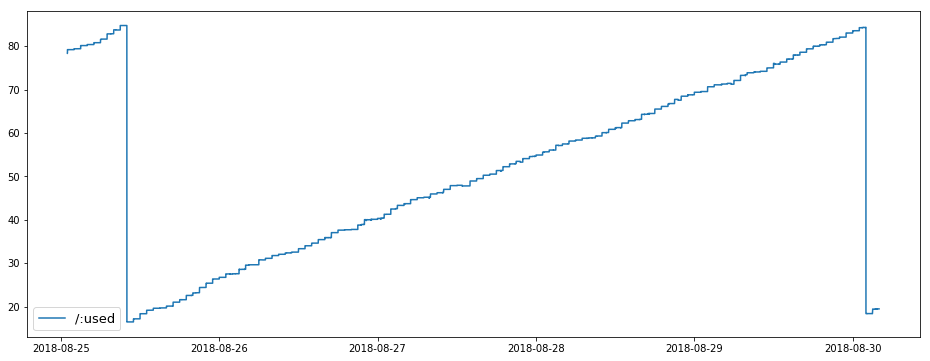

In [16]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 6
path = 'Logs ML/LAB/'
file = 'df_20180823_215637.log'
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d-%H%M%S')
df = pd.read_csv(path+file, parse_dates=['timestamp'], index_col='timestamp',date_parser=dateparse, sep = ';')
dfraw = df['/:used']
df = df['/:used']*100/8374272
plt.plot(df['2018-08-25 01':'2018-08-30 03'], label='/:used')
plt.legend(loc='best', prop={'size':13})
training_period = ['25/08/2018 11','28/08/2018 11']

### We're going to analyse a full cycle between peaks.
### We'll use training data of the first 24 hours and the remaining data will be used for testing.
### One cycle happens between 25/08/2018 11H and 30/08/2018 01H

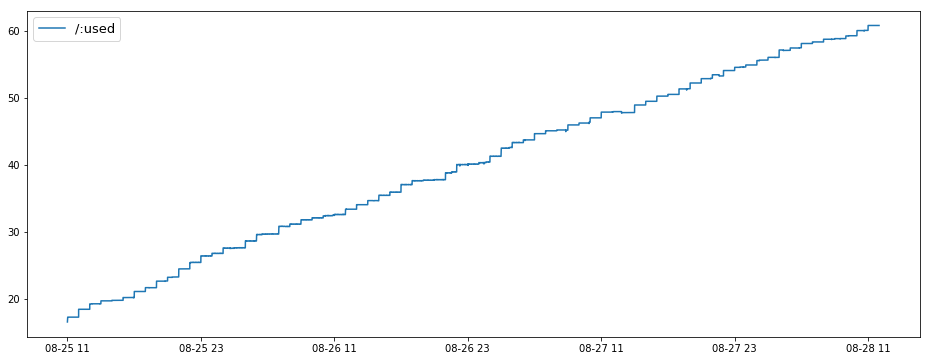

In [17]:
data = df[training_period[0]:training_period[1]]
dataraw = df[data.index]
plt.plot(data, label='/:used')
plt.legend(loc='best', prop={'size':13})

# Next, we'll fit with the following methods:
### -Simple ARIMA,
### -Auto ARIMA
### -Linear Regression

## Simple ARIMA (resample of 10min)

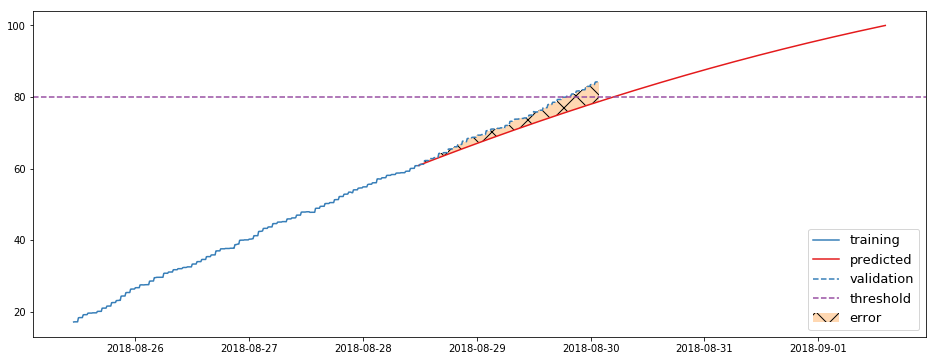

In [18]:
data = df[training_period[0]:training_period[1]].resample('10Min').mean()
training = data
origin = df[data.index[-1]:'2018-08-30 01'].resample('10Min').mean()

data = data - data.shift()
data.dropna(inplace=True)
train = data.astype('float32')
test = origin
# walk-forward validation
preddays = 432      
period = len(test) + preddays
date = pd.date_range(test.index[0], periods=period, freq='10Min')
model = ARIMA(train, order=(2,1,1)) 
results_ARIMA = model.fit(disp=-1)
predictions = results_ARIMA.forecast(steps=period)[0]


pred_diff = pd.Series(predictions, index=date)
pred_diff = pred_diff.cumsum()
pred_series = pd.Series(origin[0], index=date)
pred_series = pred_series.add(pred_diff, fill_value=0)
pred_series = pred_series[pred_series>0]
pred_series = pred_series[pred_series<100]
plt.plot(training, color ='#377eb8', label = 'training')
plt.plot(pred_series, color='#e41a1c', label= 'predicted')
plt.plot(origin, color='#377eb8', label= 'validation', linestyle='--')
plt.fill_between(origin.index,origin,pred_series[origin.index], hatch='x', facecolor='#ff7f00', label='error', alpha=0.3, step = 'mid')
plt.axhline(y = 80, linestyle='dashed', label= 'threshold', color = '#984ea3')
plt.legend(loc='best', prop={'size':13})
new_df = pd.DataFrame({'training':training,'predicted':pred_series,'validation':origin})
new_df.to_csv('3day_simple.csv', sep=';')


### Errors:

In [19]:
relative = np.abs(origin[test.index]-pred_series[test.index]).mean()*8374272/100
mse = mean_squared_error(origin[test.index],pred_series[test.index])
rmse = sqrt(mse)
print('Relative: %i bytes' %relative)
print('MSE: %0.3f' %mse)
print('RMSE: %0.3f' %rmse)

Relative: 220350 bytes
MSE: 9.151
RMSE: 3.025


## Auto ARIMA (resample of 60min)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 8760); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 8760); AIC=54.998, BIC=59.551, Fit time=0.651 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 8760); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 8760); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 8760); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 8760); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 8760); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 8760); AIC=56.886, BIC=63.716, Fit time=0.213 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 8760); AIC=56.832, BIC=63.662, Fit time=0.610 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 8760); AIC=58.996, BIC=68.103, Fit time=0.

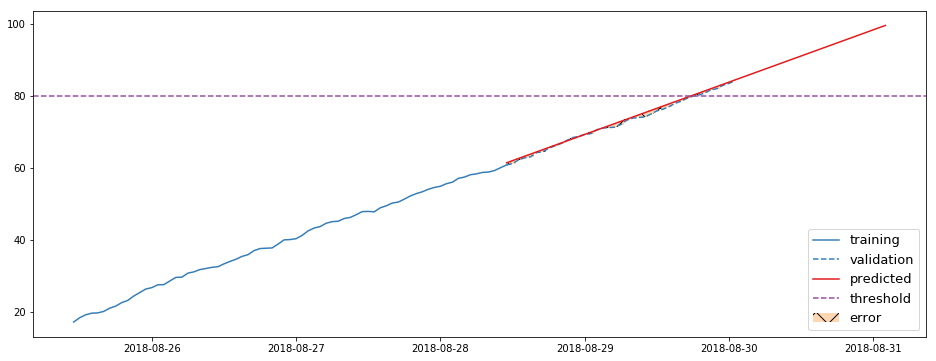

In [20]:
from pyramid.arima import auto_arima
data = df[training_period[0]:training_period[1]]
origin = df[data.index[-1]:'2018-08-30 01'].resample('60Min').mean()
used = data.resample('60Min').mean()
train_size = int(len(used))
x_train = used
y_test = origin

stepwise_model = auto_arima(x_train, m=8760,trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           )

print(stepwise_model.aic())

stepwise_model.fit(x_train)
period = len(y_test)  +24*3     #IN HOURS
forecast = stepwise_model.predict(n_periods=period)

date = pd.date_range(y_test.index[0], periods=period, freq='H')
forecast = pd.Series(forecast, index=date)
print(y_test.size)
print(forecast.size)
forecast = forecast[forecast>0]
forecast = forecast[forecast<100]
plt.plot(used, color ='#377eb8', label = 'training')
plt.plot(y_test,color='#377eb8', label= 'validation', linestyle='--')
plt.plot(forecast, color='#e41a1c', label= 'predicted')
plt.axhline(y = 80, linestyle='dashed', label= 'threshold', color = '#984ea3')
plt.fill_between(y_test.index,y_test,forecast[y_test.index], hatch='x', facecolor='#ff7f00', label='error', alpha=0.3, step = 'mid')
plt.legend(loc='best', prop={'size':13})
new_df = pd.DataFrame({'training':used,'predicted':forecast,'validation':y_test})
new_df.to_csv('3day_auto.csv', sep=';')

### Errors:

In [21]:
relative = np.abs(y_test-forecast[y_test.index]).mean()*8374272/100
mse = mean_squared_error(y_test,forecast[y_test.index])
rmse = sqrt(mse)

print('Relative: %i bytes' %relative)
print('MSE: %0.3f' %mse)
print('RMSE: %0.3f' %rmse)

Relative: 38536 bytes
MSE: 0.298
RMSE: 0.546


## Linear Regression (resample of 60min)

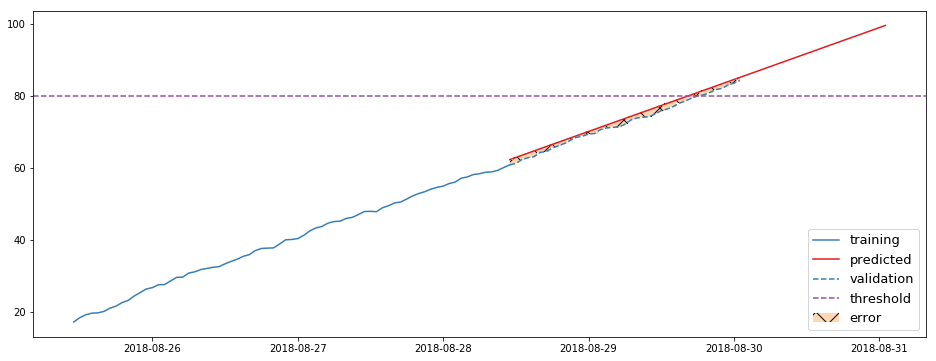

In [22]:
data = df[training_period[0]:training_period[1]]
data = data.resample('60Min').mean()
origin = df[data.index[-1]:'2018-08-30 01'].resample('60Min').mean()

from sklearn.linear_model import LinearRegression
arr = lambda x: np.array(x).reshape(-1,1)
train_size = int(len(data))
x_train = data
y_test = origin
period = len(y_test)  +72    #IN HOURS
date = pd.date_range(y_test.index[0], periods=period, freq='H')
model = LinearRegression()
model.fit(arr(range(train_size)),x_train)
pred = model.predict(arr(range(train_size,train_size+period)))
pred = pd.Series(pred, index=date)
pred = pred[pred>0]
pred = pred[pred<100]
plt.plot(data, color ='#377eb8', label = 'training')
plt.plot(pred, color='#e41a1c', label= 'predicted')
plt.plot(y_test, color='#377eb8', label= 'validation', linestyle='--')
plt.axhline(y = 80, linestyle='dashed', label= 'threshold', color = '#984ea3')
plt.fill_between(y_test.index,y_test,pred[y_test.index], hatch='x', facecolor='#ff7f00', label='error', alpha=0.3, step = 'mid')
plt.legend(loc='best', prop={'size':13})
new_df = pd.DataFrame({'training':data,'predicted':pred,'validation':y_test})
new_df.to_csv('3day_linear.csv', sep=';')

### Errors:

In [23]:
relative = np.abs(y_test-pred[y_test.index]).mean()*8374272/100
mse = mean_squared_error(y_test,pred[y_test.index])
rmse = sqrt(mse)

print('Relative: %i bytes' %relative)
print('MSE: %0.3f' %mse)
print('RMSE: %0.3f' %rmse)

Relative: 97980 bytes
MSE: 1.484
RMSE: 1.218


## Prophet (resample of 60min)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


1 days 14:00:00


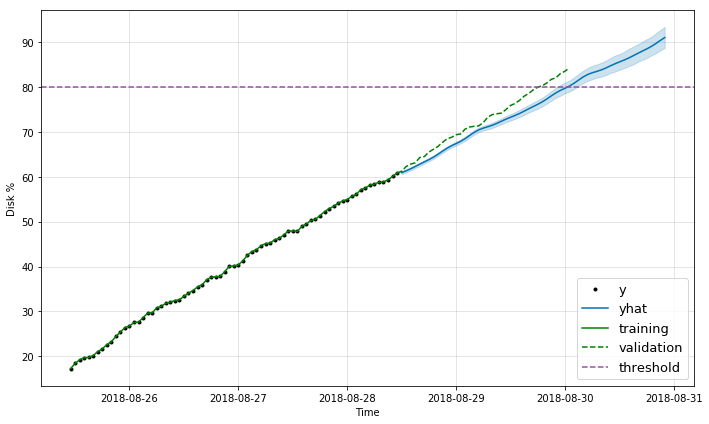

In [25]:
from fbprophet import Prophet
data = df[training_period[0]:training_period[1]].resample('1H').mean()
origin = df[training_period[0]:'2018-08-30 01'].resample('1H').mean()
validation = origin[training_period[1]:]
m=Prophet()
dummy = pd.DataFrame({'ds':data.index, 'y':data}).reset_index(drop=True)
m.fit(dummy)
period = len(validation) + 20
future = m.make_future_dataframe(period, freq='1H', include_history=False)
forecast = m.predict(future)
yhat = pd.Series(forecast['yhat'].values, index = forecast['ds'])


yhat = yhat[yhat>0]
yhat = yhat[yhat<100]

for i in range(len(yhat)):
    if yhat[i]>=80:
        break
print(yhat.index[i]  - validation.index[0])
m.plot(forecast, plot_cap=False, xlabel='Time', ylabel='Disk %')
plt.plot(data, color ='g', label = 'training')
plt.plot(validation,color='g', label= 'validation', linestyle='--')
#plt.plot(yhat, color='#e41a1c', label= 'predicted')
plt.axhline(y = 80, linestyle='dashed', label= 'threshold', color = '#984ea3')
#plt.fill_between(validation.index,yhat[:len(validation)], validation, hatch='x', facecolor='#ff7f00', label='error', alpha=0.3, step = 'mid')

plt.legend(loc=4, prop={'size':13})

new_df = pd.DataFrame({'training':data,'predicted':yhat,'validation':validation})
new_df.to_csv('3day_prophet.csv', sep=';')

### Errors:

In [ ]:
relative = np.abs(validation.values-yhat[:len(validation)].values).mean()*8374272/100
mse = mean_squared_error(validation.values,yhat[:len(validation)].values)
rmse = sqrt(mse)

print('Relative: %i bytes' %relative)
print('MSE: %0.3f' %mse)
print('RMSE: %0.3f' %rmse)